In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [3]:
from lib import fca_interp as fcai
from lib.utils_ import powerset
from importlib import reload

In [4]:
from copy import copy, deepcopy

# Load Data

In [5]:
data_dict = {}

## Adult DS

In [6]:
adult_ds = pd.read_csv(DATASETS_DIR+'/adult/adult.data', header=None)
fs = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
      'relationship', 'race', 'sex', 'capital-gain', 'capital-loss','hours-per-week','native-country',
      'y']
adult_ds.columns = fs
adult_ds['y_bin'] = adult_ds['y']==' >50K'
cat_feats = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
y_feat = 'y_bin'
train_feats = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-loss','native-country']
adult_ds.drop(train_feats,1)

print(adult_ds.shape)
adult_ds.head(2)

(32561, 16)


age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   

        marital-status        occupation    relationship    race    sex  \
0        Never-married      Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse   Exec-managerial         Husband   White   Male   

   capital-gain  capital-loss  hours-per-week  native-country       y  y_bin  
0          2174             0              40   United-States   <=50K  False  
1             0             0              13   United-States   <=50K  False

In [7]:
data_dict['adult'] = {'ds':adult_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat,}

# Test

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [9]:
from sklearn.metrics import f1_score, accuracy_score, log_loss

In [10]:
from lib import fca_interp as fcai

In [11]:
from datetime import datetime

In [12]:
data_name = 'adult'
data = data_dict[data_name]
ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']
for f in cat_feats:
    ds[f+'_le'] = LabelEncoder().fit_transform(ds[f])

In [13]:
train_idxs = ds.index[:23000]
test_idxs = ds.index[23000:]

In [14]:
X_train = ds.loc[train_idxs, [f+('_le' if f in cat_feats else '') for f in train_feats] ]
y_train = ds.loc[train_idxs, y_feat]
X_test = ds.loc[test_idxs, [f+('_le' if f in cat_feats else '') for f in train_feats] ]
y_test = ds.loc[test_idxs, y_feat]

In [15]:
stat_ds = []
for model in tqdm([DecisionTreeClassifier(), RandomForestClassifier(),
              GradientBoostingClassifier(), XGBClassifier(), LGBMClassifier()]):
    stat = {'model':model.__class__}
    
    dt1 = datetime.now()
    model.fit(X_train, y_train)
    dt2 = datetime.now()
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    
    
    stat['acc_train'] = accuracy_score(y_train, preds_train)
    stat['acc_test'] = accuracy_score(y_test, preds_test)
    stat['f1_train'] = f1_score(y_train, preds_train)
    stat['f1_test'] = f1_score(y_test, preds_test)
    stat['time'] = (dt2-dt1).total_seconds()
    
    stat_ds.append(pd.Series(stat))

In [16]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
mtrx_1 = rf.estimators_[0].decision_path(X_train)

In [18]:
mtrx_2 = rf.estimators_[1].decision_path(X_train)

In [19]:
mtrx_1.shape

(23000, 7705)

In [20]:
mtrx_2.shape

(23000, 7779)

In [21]:
mtrx_1

<23000x7705 sparse matrix of type '<class 'numpy.int64'>'
	with 381036 stored elements in Compressed Sparse Row format>

In [22]:
import scipy as sp

In [23]:
%%timeit
sp.sparse.hstack([mtrx_1, mtrx_2])

14 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
mtrx_1_csc = mtrx_1.tocsc()

In [25]:
mtrx_2_csc = mtrx_2.tocsc()

In [26]:
mtrx_1_d = mtrx_1.todense()

In [27]:
mtrx_ds = pd.DataFrame(mtrx_1_d)

In [28]:
%%time
mtrx_1_un = np.unique(mtrx_1_d, axis=1)

CPU times: user 21 s, sys: 440 ms, total: 21.5 s
Wall time: 21.5 s


In [29]:
mtrx_1_scs_d = mtrx_1_csc.todense()

In [30]:
%%time
mtrx_1_un = np.unique(mtrx_1_scs_d, axis=1)

CPU times: user 16.3 s, sys: 349 ms, total: 16.6 s
Wall time: 16.5 s


In [31]:
paths_ = rf.estimators_[0].decision_path(X_train)

In [32]:
rf.estimators_[0].tree_.children_left

array([ 1,  2,  3, ..., -1, -1, -1])

In [33]:
rf.estimators_[0].tree_.children_right

array([6364,  667,   36, ...,   -1,   -1,   -1])

In [34]:
paths = rf.decision_path(X_train)[0]

In [35]:
paths = paths.tocsc()

In [36]:
m = paths.sum(0)

In [37]:
len(m.tolist()[0])

771606

In [38]:
ser = pd.Series(m.tolist()[0])

In [39]:
def sparse_unique_columns(M):
    M = M.tocsc()
    m, n = M.shape
    if not M.has_sorted_indices:
        M.sort_indices()
    if not M.has_canonical_format:
        M.sum_duplicates()
    sizes = np.diff(M.indptr)
    idx = np.argsort(sizes)
    Ms = M@sp.sparse.csc_matrix((np.ones((n,)), idx, np.arange(n+1)), (n, n))
    ssizes = np.diff(Ms.indptr)
    ssizes[1:] -= ssizes[:-1]
    grpidx, = np.where(ssizes)
    grpidx = np.concatenate([grpidx, [n]])
    if ssizes[0] == 0:
        counts = [np.array([0, grpidx[0]])]
    else:
        counts = [np.zeros((1,), int)]
    ssizes = ssizes[grpidx[:-1]].cumsum()
    for i, ss in enumerate(ssizes):
        gil, gir = grpidx[i:i+2]
        pl, pr = Ms.indptr[[gil, gir]]
        dv = Ms.data[pl:pr].view(f'V{ss*Ms.data.dtype.itemsize}')
        iv = Ms.indices[pl:pr].view(f'V{ss*Ms.indices.dtype.itemsize}')
        idxi = np.lexsort((dv, iv))
        dv = dv[idxi]
        iv = iv[idxi]
        chng, = np.where(np.concatenate(
            [[True], (dv[1:] != dv[:-1]) | (iv[1:] != iv[:-1]), [True]]))
        counts.append(np.diff(chng))
        idx[gil:gir] = idx[gil:gir][idxi]
    counts = np.concatenate(counts)
    nu = counts.size - 1
    uniques = M@sp.sparse.csc_matrix((np.ones((nu,)), idx[counts[:-1].cumsum()],
                                   np.arange(nu + 1)), (n, nu))
    return uniques, idx, counts[1:]

In [40]:
unq, idx, cnt  = sparse_unique_columns(paths)

In [41]:
ser = pd.Series(unq.sum(0).tolist()[0])

In [42]:
idxs = list(ser[(ser>=1000)].index)
len(idxs)

4518

In [43]:
paths_short = unq[:,idxs]

In [44]:
f = lambda i, paths, objs: tuple(objs[(paths[:, i] == 1).todense().flatten().tolist()[0]])

In [45]:
from joblib import Parallel, delayed

In [46]:
n_jobs = -1

In [47]:
%%time
exts = Parallel(n_jobs)([delayed(f)(i, paths_short, X_train.index) for i in range(paths_short.shape[1])])

CPU times: user 1.14 s, sys: 495 ms, total: 1.64 s
Wall time: 16.2 s


In [86]:
from lib import pattern_structure, abstract_context

In [122]:
abstract_context = reload(abstract_context)

In [123]:
pattern_structure = reload(pattern_structure)

In [124]:
fcai = reload(fcai)

In [74]:
cntx_train_small = fcai.MultiValuedContext(ds.loc[train_idxs, train_feats].head(100), y_true=y_train[:100], cat_attrs=cat_feats)
cntx_test_small = fcai.MultiValuedContext(ds.loc[test_idxs, train_feats].head(100), cat_attrs=cat_feats)

In [75]:
%%time

cntx_train = fcai.MultiValuedContext(ds.loc[train_idxs, train_feats], y_true=y_train, cat_attrs=cat_feats)
cntx_test = fcai.MultiValuedContext(ds.loc[test_idxs, train_feats], cat_attrs=cat_feats)

#fm = fcai.FormalManager(cntx_train)
#fm.construct_concepts(algo='RandomForest', rf_params={'n_estimators':2, 'max_depth':5}, use_tqdm=True)
#fm.construct_concepts(algo='RandomForest', rf_params={}, use_tqdm=True)

CPU times: user 34.4 ms, sys: 3.99 ms, total: 38.4 ms
Wall time: 37.1 ms


In [54]:
rf_params = {'n_estimators':2, 'max_depth':None}

In [55]:
fm = fcai.FormalManager(cntx_train_small)
fm.construct_concepts(algo='RandomForest', rf_params=rf_params)

/root/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [56]:
xaxis = [1,10,100,300,600,1000,3000]#,10000]
yaxis_old = []
yaxis_new = []
for x in tqdm(xaxis):
    cntx_train_small = fcai.MultiValuedContext(
        ds.loc[train_idxs, train_feats].head(x),
        y_true=y_train[:x], cat_attrs=cat_feats)
    fm = fcai.FormalManager(cntx_train_small)
    
    t1 = datetime.now()
    concepts_ = fm._random_forest_concepts_old(rf_params=rf_params)
    t2 = datetime.now()
    yaxis_old.append((t2-t1).total_seconds())
    
    t1 = datetime.now()
    concepts_ = fm._random_forest_concepts(rf_params=rf_params)
    t2 = datetime.now()
    yaxis_new.append((t2-t1).total_seconds())

xaxis [1, 10, 100, 300, 600, 1000, 3000]
yaxis old [1.389184, 1.632944, 2.193463, 2.349567, 2.212209, 1.746838, 7.772128]
yaxis new [0.016804, 0.028944, 0.040467, 0.113931, 0.219746, 0.427443, 1.395569]


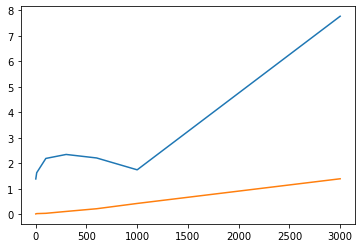

In [57]:
plt.plot(xaxis[:], yaxis_old)
plt.plot(xaxis[:], yaxis_new)
print('xaxis', xaxis)
print('yaxis old', yaxis_old)
print('yaxis new', yaxis_new)

In [125]:
rf_params = {'n_estimators':100, 'max_depth':None}

In [126]:
xaxis = [1,10,100,300,600,1000,3000,10000, 30000]
yaxis = []
for x in tqdm(xaxis):
    cntx_train_small = fcai.MultiValuedContext(
        ds.loc[train_idxs, train_feats].head(x),
        y_true=y_train[:x], cat_attrs=cat_feats)
    fm = fcai.FormalManager(cntx_train_small, n_jobs=1)
    
    t1 = datetime.now()
    fm.construct_concepts(algo='RandomForest', rf_params=rf_params)
    t2 = datetime.now()
    yaxis.append((t2-t1).total_seconds())

KeyboardInterrupt: 

In [127]:
xaxis = [1,10,100,300,600,1000,3000,10000, 30000]
yaxis_new = []
for x in tqdm(xaxis[:5]):
    cntx_train_small = fcai.MultiValuedContext(
        ds.loc[train_idxs, train_feats].head(x),
        y_true=y_train[:x], cat_attrs=cat_feats)
    fm = fcai.FormalManager(cntx_train_small, n_jobs=1)
    
    t1 = datetime.now()
    fm.construct_concepts(algo='RandomForest', rf_params=rf_params)
    t2 = datetime.now()
    yaxis_new.append((t2-t1).total_seconds())

In [128]:
fm.construct_lattice(True, True)

In [130]:
preds = fm.predict_context(cntx_test_small)

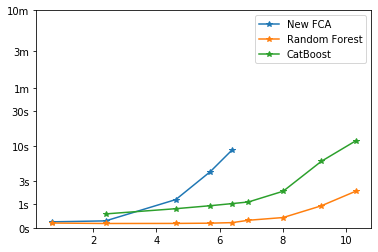

In [148]:
#plt.plot(np.log1p(xaxis), np.log1p(yaxis), '*-')
plt.plot(np.log1p(xaxis[:len(yaxis_new)]), np.log1p(yaxis_new), '*-', label='New FCA')
plt.plot(np.log1p(xaxis), np.log1p(yaxis_rf), '*-', label='Random Forest')
plt.plot(np.log1p(xaxis[1:]), np.log1p(yaxis_cb), '*-', label='CatBoost')
plt.yticks(np.log1p([0,1,3, 10,30,60,180,600]), ['0s','1s','3s','10s','30s','1m', '3m','10m'])
plt.legend()
plt.show()

In [149]:
cb

In [138]:
xaxis = [1,10,100,300,600,1000,3000,10000, 30000]
yaxis_cb = []
for x in tqdm(xaxis[1:]):
    t1 = datetime.now()
    cb = CatBoostClassifier()
    cb.fit(X_train[:x], y_train[:x])
    t2 = datetime.now()
    yaxis_cb.append((t2-t1).total_seconds())

Learning rate set to 0.001442
0:	learn: 0.6924130	total: 51.7ms	remaining: 51.7s
1:	learn: 0.6913934	total: 52.2ms	remaining: 26.1s
2:	learn: 0.6907458	total: 52.7ms	remaining: 17.5s
3:	learn: 0.6901366	total: 53.2ms	remaining: 13.3s
4:	learn: 0.6895684	total: 53.6ms	remaining: 10.7s
5:	learn: 0.6890850	total: 54ms	remaining: 8.94s
6:	learn: 0.6886390	total: 54.2ms	remaining: 7.68s
7:	learn: 0.6879953	total: 54.4ms	remaining: 6.75s
8:	learn: 0.6873890	total: 54.7ms	remaining: 6.03s
9:	learn: 0.6865023	total: 55ms	remaining: 5.44s
10:	learn: 0.6851803	total: 55.2ms	remaining: 4.96s
11:	learn: 0.6848616	total: 55.5ms	remaining: 4.57s
12:	learn: 0.6842304	total: 55.7ms	remaining: 4.22s
13:	learn: 0.6834320	total: 55.9ms	remaining: 3.94s
14:	learn: 0.6828325	total: 56.2ms	remaining: 3.69s
15:	learn: 0.6821487	total: 56.4ms	remaining: 3.47s
16:	learn: 0.6813535	total: 56.6ms	remaining: 3.27s
17:	learn: 0.6805595	total: 56.9ms	remaining: 3.1s
18:	learn: 0.6797601	total: 57.3ms	remaining: 2.9

391:	learn: 0.4920070	total: 172ms	remaining: 267ms
392:	learn: 0.4912757	total: 179ms	remaining: 276ms
393:	learn: 0.4907978	total: 179ms	remaining: 275ms
394:	learn: 0.4906639	total: 179ms	remaining: 274ms
395:	learn: 0.4902814	total: 179ms	remaining: 274ms
396:	learn: 0.4900582	total: 180ms	remaining: 273ms
397:	learn: 0.4894936	total: 180ms	remaining: 272ms
398:	learn: 0.4887616	total: 180ms	remaining: 271ms
399:	learn: 0.4880979	total: 180ms	remaining: 271ms
400:	learn: 0.4875458	total: 181ms	remaining: 270ms
401:	learn: 0.4870440	total: 181ms	remaining: 269ms
402:	learn: 0.4866185	total: 181ms	remaining: 268ms
403:	learn: 0.4862460	total: 181ms	remaining: 268ms
404:	learn: 0.4858066	total: 182ms	remaining: 267ms
405:	learn: 0.4854912	total: 182ms	remaining: 266ms
406:	learn: 0.4852598	total: 182ms	remaining: 265ms
407:	learn: 0.4848922	total: 182ms	remaining: 265ms
408:	learn: 0.4844729	total: 183ms	remaining: 264ms
409:	learn: 0.4842311	total: 183ms	remaining: 263ms
410:	learn: 

959:	learn: 0.3176249	total: 335ms	remaining: 14ms
960:	learn: 0.3174160	total: 335ms	remaining: 13.6ms
961:	learn: 0.3171218	total: 336ms	remaining: 13.3ms
962:	learn: 0.3169189	total: 336ms	remaining: 12.9ms
963:	learn: 0.3168606	total: 337ms	remaining: 12.6ms
964:	learn: 0.3165689	total: 337ms	remaining: 12.2ms
965:	learn: 0.3163722	total: 338ms	remaining: 11.9ms
966:	learn: 0.3161407	total: 338ms	remaining: 11.5ms
967:	learn: 0.3158021	total: 338ms	remaining: 11.2ms
968:	learn: 0.3156159	total: 339ms	remaining: 10.8ms
969:	learn: 0.3153503	total: 339ms	remaining: 10.5ms
970:	learn: 0.3150851	total: 342ms	remaining: 10.2ms
971:	learn: 0.3149057	total: 343ms	remaining: 9.87ms
972:	learn: 0.3147167	total: 343ms	remaining: 9.52ms
973:	learn: 0.3145705	total: 343ms	remaining: 9.16ms
974:	learn: 0.3141989	total: 343ms	remaining: 8.81ms
975:	learn: 0.3139609	total: 344ms	remaining: 8.45ms
976:	learn: 0.3135952	total: 344ms	remaining: 8.1ms
977:	learn: 0.3134785	total: 344ms	remaining: 7.7

371:	learn: 0.3047080	total: 264ms	remaining: 446ms
372:	learn: 0.3041422	total: 266ms	remaining: 448ms
373:	learn: 0.3034462	total: 267ms	remaining: 447ms
374:	learn: 0.3028507	total: 268ms	remaining: 446ms
375:	learn: 0.3024207	total: 268ms	remaining: 445ms
376:	learn: 0.3017129	total: 268ms	remaining: 443ms
377:	learn: 0.3011307	total: 269ms	remaining: 442ms
378:	learn: 0.3005160	total: 269ms	remaining: 441ms
379:	learn: 0.3003441	total: 269ms	remaining: 439ms
380:	learn: 0.2997322	total: 270ms	remaining: 438ms
381:	learn: 0.2993741	total: 270ms	remaining: 437ms
382:	learn: 0.2988464	total: 270ms	remaining: 436ms
383:	learn: 0.2980920	total: 271ms	remaining: 435ms
384:	learn: 0.2976889	total: 275ms	remaining: 439ms
385:	learn: 0.2971511	total: 276ms	remaining: 439ms
386:	learn: 0.2967236	total: 277ms	remaining: 439ms
387:	learn: 0.2960305	total: 277ms	remaining: 438ms
388:	learn: 0.2956945	total: 278ms	remaining: 437ms
389:	learn: 0.2949987	total: 278ms	remaining: 435ms
390:	learn: 

752:	learn: 0.1807656	total: 440ms	remaining: 144ms
753:	learn: 0.1805958	total: 442ms	remaining: 144ms
754:	learn: 0.1803824	total: 443ms	remaining: 144ms
755:	learn: 0.1802259	total: 443ms	remaining: 143ms
756:	learn: 0.1800102	total: 444ms	remaining: 142ms
757:	learn: 0.1799169	total: 444ms	remaining: 142ms
758:	learn: 0.1797095	total: 445ms	remaining: 141ms
759:	learn: 0.1794957	total: 445ms	remaining: 141ms
760:	learn: 0.1792711	total: 446ms	remaining: 140ms
761:	learn: 0.1791198	total: 446ms	remaining: 139ms
762:	learn: 0.1788914	total: 447ms	remaining: 139ms
763:	learn: 0.1787258	total: 447ms	remaining: 138ms
764:	learn: 0.1785496	total: 448ms	remaining: 138ms
765:	learn: 0.1784129	total: 448ms	remaining: 137ms
766:	learn: 0.1782814	total: 449ms	remaining: 136ms
767:	learn: 0.1780697	total: 450ms	remaining: 136ms
768:	learn: 0.1778992	total: 450ms	remaining: 135ms
769:	learn: 0.1776080	total: 451ms	remaining: 135ms
770:	learn: 0.1773790	total: 451ms	remaining: 134ms
771:	learn: 

Learning rate set to 0.006161
0:	learn: 0.6887955	total: 5.67ms	remaining: 5.66s
1:	learn: 0.6837243	total: 8.74ms	remaining: 4.36s
2:	learn: 0.6807023	total: 11.6ms	remaining: 3.85s
3:	learn: 0.6761751	total: 13.5ms	remaining: 3.35s
4:	learn: 0.6713197	total: 15.4ms	remaining: 3.06s
5:	learn: 0.6674771	total: 17.3ms	remaining: 2.87s
6:	learn: 0.6635872	total: 19.2ms	remaining: 2.72s
7:	learn: 0.6599145	total: 20.7ms	remaining: 2.56s
8:	learn: 0.6555664	total: 22.1ms	remaining: 2.44s
9:	learn: 0.6525679	total: 23.6ms	remaining: 2.33s
10:	learn: 0.6482332	total: 25ms	remaining: 2.25s
11:	learn: 0.6450392	total: 26.4ms	remaining: 2.17s
12:	learn: 0.6405240	total: 28ms	remaining: 2.12s
13:	learn: 0.6367801	total: 29.5ms	remaining: 2.08s
14:	learn: 0.6335794	total: 31.2ms	remaining: 2.05s
15:	learn: 0.6309585	total: 34.3ms	remaining: 2.11s
16:	learn: 0.6280030	total: 35.6ms	remaining: 2.06s
17:	learn: 0.6247295	total: 36.6ms	remaining: 2s
18:	learn: 0.6213048	total: 37.7ms	remaining: 1.95s

191:	learn: 0.3651765	total: 179ms	remaining: 754ms
192:	learn: 0.3642676	total: 180ms	remaining: 753ms
193:	learn: 0.3637595	total: 181ms	remaining: 752ms
194:	learn: 0.3629707	total: 182ms	remaining: 751ms
195:	learn: 0.3622975	total: 183ms	remaining: 749ms
196:	learn: 0.3615286	total: 183ms	remaining: 747ms
197:	learn: 0.3605466	total: 184ms	remaining: 746ms
198:	learn: 0.3599686	total: 185ms	remaining: 744ms
199:	learn: 0.3594684	total: 186ms	remaining: 742ms
200:	learn: 0.3587787	total: 186ms	remaining: 740ms
201:	learn: 0.3580589	total: 187ms	remaining: 739ms
202:	learn: 0.3573478	total: 188ms	remaining: 737ms
203:	learn: 0.3568442	total: 189ms	remaining: 736ms
204:	learn: 0.3564085	total: 189ms	remaining: 735ms
205:	learn: 0.3557450	total: 190ms	remaining: 733ms
206:	learn: 0.3551721	total: 191ms	remaining: 733ms
207:	learn: 0.3547864	total: 192ms	remaining: 732ms
208:	learn: 0.3541418	total: 193ms	remaining: 730ms
209:	learn: 0.3531131	total: 194ms	remaining: 729ms
210:	learn: 

452:	learn: 0.2522389	total: 361ms	remaining: 436ms
453:	learn: 0.2520484	total: 362ms	remaining: 436ms
454:	learn: 0.2517560	total: 367ms	remaining: 439ms
455:	learn: 0.2516067	total: 367ms	remaining: 438ms
456:	learn: 0.2512710	total: 368ms	remaining: 438ms
457:	learn: 0.2510898	total: 369ms	remaining: 437ms
458:	learn: 0.2508382	total: 370ms	remaining: 436ms
459:	learn: 0.2506663	total: 371ms	remaining: 435ms
460:	learn: 0.2504773	total: 372ms	remaining: 435ms
461:	learn: 0.2503808	total: 373ms	remaining: 434ms
462:	learn: 0.2500232	total: 374ms	remaining: 433ms
463:	learn: 0.2497243	total: 374ms	remaining: 433ms
464:	learn: 0.2495420	total: 375ms	remaining: 432ms
465:	learn: 0.2491113	total: 376ms	remaining: 431ms
466:	learn: 0.2488422	total: 377ms	remaining: 431ms
467:	learn: 0.2487408	total: 378ms	remaining: 430ms
468:	learn: 0.2485057	total: 379ms	remaining: 429ms
469:	learn: 0.2483124	total: 380ms	remaining: 428ms
470:	learn: 0.2481326	total: 381ms	remaining: 428ms
471:	learn: 

708:	learn: 0.1959587	total: 545ms	remaining: 224ms
709:	learn: 0.1958390	total: 561ms	remaining: 229ms
710:	learn: 0.1957522	total: 562ms	remaining: 228ms
711:	learn: 0.1955422	total: 563ms	remaining: 228ms
712:	learn: 0.1952911	total: 563ms	remaining: 227ms
713:	learn: 0.1952136	total: 564ms	remaining: 226ms
714:	learn: 0.1951423	total: 565ms	remaining: 225ms
715:	learn: 0.1949170	total: 566ms	remaining: 225ms
716:	learn: 0.1948051	total: 567ms	remaining: 224ms
717:	learn: 0.1947160	total: 568ms	remaining: 223ms
718:	learn: 0.1945058	total: 569ms	remaining: 222ms
719:	learn: 0.1943217	total: 569ms	remaining: 221ms
720:	learn: 0.1942809	total: 570ms	remaining: 221ms
721:	learn: 0.1940956	total: 571ms	remaining: 220ms
722:	learn: 0.1939185	total: 571ms	remaining: 219ms
723:	learn: 0.1936439	total: 572ms	remaining: 218ms
724:	learn: 0.1934432	total: 574ms	remaining: 218ms
725:	learn: 0.1934327	total: 575ms	remaining: 217ms
726:	learn: 0.1932702	total: 575ms	remaining: 216ms
727:	learn: 

954:	learn: 0.1561154	total: 729ms	remaining: 34.4ms
955:	learn: 0.1559845	total: 730ms	remaining: 33.6ms
956:	learn: 0.1558605	total: 731ms	remaining: 32.9ms
957:	learn: 0.1557852	total: 732ms	remaining: 32.1ms
958:	learn: 0.1556828	total: 733ms	remaining: 31.3ms
959:	learn: 0.1554312	total: 733ms	remaining: 30.6ms
960:	learn: 0.1552924	total: 734ms	remaining: 29.8ms
961:	learn: 0.1551224	total: 735ms	remaining: 29ms
962:	learn: 0.1549723	total: 736ms	remaining: 28.3ms
963:	learn: 0.1549129	total: 736ms	remaining: 27.5ms
964:	learn: 0.1548938	total: 737ms	remaining: 26.7ms
965:	learn: 0.1546993	total: 738ms	remaining: 26ms
966:	learn: 0.1544729	total: 738ms	remaining: 25.2ms
967:	learn: 0.1542730	total: 739ms	remaining: 24.4ms
968:	learn: 0.1540563	total: 740ms	remaining: 23.7ms
969:	learn: 0.1539726	total: 741ms	remaining: 22.9ms
970:	learn: 0.1538388	total: 741ms	remaining: 22.1ms
971:	learn: 0.1536873	total: 742ms	remaining: 21.4ms
972:	learn: 0.1535874	total: 743ms	remaining: 20.6

254:	learn: 0.3094085	total: 263ms	remaining: 769ms
255:	learn: 0.3090596	total: 264ms	remaining: 768ms
256:	learn: 0.3087664	total: 265ms	remaining: 767ms
257:	learn: 0.3083928	total: 266ms	remaining: 766ms
258:	learn: 0.3077398	total: 267ms	remaining: 765ms
259:	learn: 0.3074985	total: 268ms	remaining: 763ms
260:	learn: 0.3070708	total: 269ms	remaining: 762ms
261:	learn: 0.3065407	total: 270ms	remaining: 761ms
262:	learn: 0.3060672	total: 271ms	remaining: 760ms
263:	learn: 0.3055186	total: 272ms	remaining: 758ms
264:	learn: 0.3052199	total: 273ms	remaining: 757ms
265:	learn: 0.3046660	total: 274ms	remaining: 755ms
266:	learn: 0.3043162	total: 275ms	remaining: 754ms
267:	learn: 0.3038730	total: 276ms	remaining: 753ms
268:	learn: 0.3036265	total: 276ms	remaining: 751ms
269:	learn: 0.3031401	total: 278ms	remaining: 750ms
270:	learn: 0.3028798	total: 278ms	remaining: 749ms
271:	learn: 0.3026144	total: 279ms	remaining: 748ms
272:	learn: 0.3021644	total: 280ms	remaining: 747ms
273:	learn: 

479:	learn: 0.2499937	total: 447ms	remaining: 485ms
480:	learn: 0.2496284	total: 449ms	remaining: 484ms
481:	learn: 0.2494272	total: 450ms	remaining: 483ms
482:	learn: 0.2491398	total: 451ms	remaining: 483ms
483:	learn: 0.2489885	total: 452ms	remaining: 482ms
484:	learn: 0.2487664	total: 453ms	remaining: 481ms
485:	learn: 0.2482939	total: 454ms	remaining: 480ms
486:	learn: 0.2481173	total: 455ms	remaining: 479ms
487:	learn: 0.2477491	total: 456ms	remaining: 479ms
488:	learn: 0.2475883	total: 458ms	remaining: 478ms
489:	learn: 0.2474478	total: 459ms	remaining: 478ms
490:	learn: 0.2472887	total: 460ms	remaining: 477ms
491:	learn: 0.2471145	total: 462ms	remaining: 477ms
492:	learn: 0.2469882	total: 463ms	remaining: 476ms
493:	learn: 0.2467617	total: 470ms	remaining: 482ms
494:	learn: 0.2466871	total: 473ms	remaining: 483ms
495:	learn: 0.2464045	total: 475ms	remaining: 483ms
496:	learn: 0.2461598	total: 476ms	remaining: 482ms
497:	learn: 0.2460290	total: 477ms	remaining: 481ms
498:	learn: 

668:	learn: 0.2180768	total: 632ms	remaining: 313ms
669:	learn: 0.2179635	total: 633ms	remaining: 312ms
670:	learn: 0.2178783	total: 634ms	remaining: 311ms
671:	learn: 0.2176532	total: 635ms	remaining: 310ms
672:	learn: 0.2174962	total: 636ms	remaining: 309ms
673:	learn: 0.2173303	total: 637ms	remaining: 308ms
674:	learn: 0.2172551	total: 638ms	remaining: 307ms
675:	learn: 0.2171782	total: 639ms	remaining: 306ms
676:	learn: 0.2170604	total: 640ms	remaining: 305ms
677:	learn: 0.2169724	total: 641ms	remaining: 305ms
678:	learn: 0.2168622	total: 642ms	remaining: 304ms
679:	learn: 0.2167006	total: 643ms	remaining: 303ms
680:	learn: 0.2166317	total: 644ms	remaining: 302ms
681:	learn: 0.2164274	total: 645ms	remaining: 301ms
682:	learn: 0.2162656	total: 646ms	remaining: 300ms
683:	learn: 0.2161559	total: 647ms	remaining: 299ms
684:	learn: 0.2159471	total: 648ms	remaining: 298ms
685:	learn: 0.2157158	total: 649ms	remaining: 297ms
686:	learn: 0.2154226	total: 650ms	remaining: 296ms
687:	learn: 

899:	learn: 0.1813334	total: 816ms	remaining: 90.6ms
900:	learn: 0.1812199	total: 817ms	remaining: 89.7ms
901:	learn: 0.1810484	total: 818ms	remaining: 88.9ms
902:	learn: 0.1808683	total: 819ms	remaining: 88ms
903:	learn: 0.1807016	total: 820ms	remaining: 87ms
904:	learn: 0.1804555	total: 821ms	remaining: 86.1ms
905:	learn: 0.1804128	total: 822ms	remaining: 85.2ms
906:	learn: 0.1802797	total: 823ms	remaining: 84.3ms
907:	learn: 0.1801989	total: 823ms	remaining: 83.4ms
908:	learn: 0.1801693	total: 824ms	remaining: 82.5ms
909:	learn: 0.1799615	total: 825ms	remaining: 81.6ms
910:	learn: 0.1798635	total: 826ms	remaining: 80.7ms
911:	learn: 0.1797178	total: 827ms	remaining: 79.8ms
912:	learn: 0.1796373	total: 828ms	remaining: 78.9ms
913:	learn: 0.1795125	total: 829ms	remaining: 78ms
914:	learn: 0.1794753	total: 830ms	remaining: 77.1ms
915:	learn: 0.1793360	total: 831ms	remaining: 76.2ms
916:	learn: 0.1791973	total: 832ms	remaining: 75.3ms
917:	learn: 0.1791404	total: 833ms	remaining: 74.4ms

225:	learn: 0.3094366	total: 247ms	remaining: 847ms
226:	learn: 0.3089524	total: 249ms	remaining: 847ms
227:	learn: 0.3087548	total: 250ms	remaining: 847ms
228:	learn: 0.3083022	total: 251ms	remaining: 846ms
229:	learn: 0.3080888	total: 253ms	remaining: 845ms
230:	learn: 0.3076996	total: 254ms	remaining: 845ms
231:	learn: 0.3075520	total: 255ms	remaining: 843ms
232:	learn: 0.3071892	total: 256ms	remaining: 842ms
233:	learn: 0.3067149	total: 257ms	remaining: 841ms
234:	learn: 0.3065371	total: 258ms	remaining: 841ms
235:	learn: 0.3063355	total: 260ms	remaining: 842ms
236:	learn: 0.3063104	total: 261ms	remaining: 839ms
237:	learn: 0.3059062	total: 262ms	remaining: 838ms
238:	learn: 0.3057252	total: 263ms	remaining: 838ms
239:	learn: 0.3054809	total: 264ms	remaining: 836ms
240:	learn: 0.3050539	total: 265ms	remaining: 835ms
241:	learn: 0.3046647	total: 266ms	remaining: 834ms
242:	learn: 0.3041728	total: 267ms	remaining: 833ms
243:	learn: 0.3039947	total: 269ms	remaining: 832ms
244:	learn: 

419:	learn: 0.2622515	total: 433ms	remaining: 597ms
420:	learn: 0.2620718	total: 437ms	remaining: 601ms
421:	learn: 0.2619141	total: 438ms	remaining: 600ms
422:	learn: 0.2616613	total: 439ms	remaining: 599ms
423:	learn: 0.2613772	total: 440ms	remaining: 598ms
424:	learn: 0.2612732	total: 442ms	remaining: 598ms
425:	learn: 0.2611391	total: 443ms	remaining: 597ms
426:	learn: 0.2610551	total: 444ms	remaining: 596ms
427:	learn: 0.2609914	total: 445ms	remaining: 595ms
428:	learn: 0.2607462	total: 446ms	remaining: 594ms
429:	learn: 0.2605722	total: 448ms	remaining: 594ms
430:	learn: 0.2604712	total: 449ms	remaining: 593ms
431:	learn: 0.2603530	total: 451ms	remaining: 593ms
432:	learn: 0.2602263	total: 452ms	remaining: 592ms
433:	learn: 0.2600688	total: 454ms	remaining: 592ms
434:	learn: 0.2596726	total: 455ms	remaining: 591ms
435:	learn: 0.2596266	total: 456ms	remaining: 589ms
436:	learn: 0.2594454	total: 457ms	remaining: 589ms
437:	learn: 0.2592398	total: 458ms	remaining: 588ms
438:	learn: 

613:	learn: 0.2306018	total: 621ms	remaining: 391ms
614:	learn: 0.2304465	total: 623ms	remaining: 390ms
615:	learn: 0.2303346	total: 624ms	remaining: 389ms
616:	learn: 0.2302108	total: 624ms	remaining: 388ms
617:	learn: 0.2300156	total: 625ms	remaining: 387ms
618:	learn: 0.2299600	total: 627ms	remaining: 386ms
619:	learn: 0.2298694	total: 628ms	remaining: 385ms
620:	learn: 0.2297041	total: 629ms	remaining: 384ms
621:	learn: 0.2294985	total: 630ms	remaining: 383ms
622:	learn: 0.2292761	total: 631ms	remaining: 382ms
623:	learn: 0.2289867	total: 632ms	remaining: 381ms
624:	learn: 0.2287147	total: 633ms	remaining: 380ms
625:	learn: 0.2286389	total: 634ms	remaining: 379ms
626:	learn: 0.2284149	total: 635ms	remaining: 378ms
627:	learn: 0.2283314	total: 636ms	remaining: 377ms
628:	learn: 0.2282176	total: 637ms	remaining: 376ms
629:	learn: 0.2281099	total: 638ms	remaining: 375ms
630:	learn: 0.2279829	total: 640ms	remaining: 374ms
631:	learn: 0.2278260	total: 641ms	remaining: 373ms
632:	learn: 

810:	learn: 0.2000248	total: 807ms	remaining: 188ms
811:	learn: 0.1999179	total: 809ms	remaining: 187ms
812:	learn: 0.1997620	total: 811ms	remaining: 186ms
813:	learn: 0.1996260	total: 812ms	remaining: 186ms
814:	learn: 0.1994200	total: 813ms	remaining: 185ms
815:	learn: 0.1992585	total: 814ms	remaining: 184ms
816:	learn: 0.1990560	total: 815ms	remaining: 183ms
817:	learn: 0.1989780	total: 816ms	remaining: 182ms
818:	learn: 0.1987949	total: 817ms	remaining: 181ms
819:	learn: 0.1985567	total: 818ms	remaining: 180ms
820:	learn: 0.1985013	total: 819ms	remaining: 179ms
821:	learn: 0.1983811	total: 820ms	remaining: 178ms
822:	learn: 0.1983716	total: 821ms	remaining: 177ms
823:	learn: 0.1981602	total: 822ms	remaining: 176ms
824:	learn: 0.1980130	total: 824ms	remaining: 175ms
825:	learn: 0.1979219	total: 825ms	remaining: 174ms
826:	learn: 0.1978198	total: 827ms	remaining: 173ms
827:	learn: 0.1975588	total: 828ms	remaining: 172ms
828:	learn: 0.1972593	total: 829ms	remaining: 171ms
829:	learn: 

Learning rate set to 0.016469
0:	learn: 0.6798107	total: 3.39ms	remaining: 3.39s
1:	learn: 0.6659769	total: 7.06ms	remaining: 3.52s
2:	learn: 0.6547993	total: 11.4ms	remaining: 3.77s
3:	learn: 0.6430930	total: 17.4ms	remaining: 4.34s
4:	learn: 0.6301895	total: 21.5ms	remaining: 4.28s
5:	learn: 0.6189651	total: 29.2ms	remaining: 4.83s
6:	learn: 0.6099421	total: 32ms	remaining: 4.54s
7:	learn: 0.5992328	total: 34.6ms	remaining: 4.29s
8:	learn: 0.5881342	total: 40.1ms	remaining: 4.41s
9:	learn: 0.5785477	total: 42.8ms	remaining: 4.23s
10:	learn: 0.5698428	total: 44.9ms	remaining: 4.04s
11:	learn: 0.5630736	total: 49.5ms	remaining: 4.07s
12:	learn: 0.5539921	total: 54.6ms	remaining: 4.15s
13:	learn: 0.5473783	total: 58.2ms	remaining: 4.1s
14:	learn: 0.5390883	total: 61.3ms	remaining: 4.02s
15:	learn: 0.5337120	total: 64.4ms	remaining: 3.96s
16:	learn: 0.5263033	total: 67.5ms	remaining: 3.9s
17:	learn: 0.5193100	total: 70.5ms	remaining: 3.85s
18:	learn: 0.5122321	total: 73.2ms	remaining: 3.

199:	learn: 0.3281258	total: 381ms	remaining: 1.52s
200:	learn: 0.3279304	total: 385ms	remaining: 1.53s
201:	learn: 0.3277644	total: 389ms	remaining: 1.54s
202:	learn: 0.3276539	total: 392ms	remaining: 1.54s
203:	learn: 0.3273872	total: 396ms	remaining: 1.54s
204:	learn: 0.3271098	total: 398ms	remaining: 1.54s
205:	learn: 0.3267671	total: 402ms	remaining: 1.55s
206:	learn: 0.3264266	total: 405ms	remaining: 1.55s
207:	learn: 0.3261240	total: 408ms	remaining: 1.55s
208:	learn: 0.3259571	total: 413ms	remaining: 1.56s
209:	learn: 0.3258087	total: 415ms	remaining: 1.56s
210:	learn: 0.3257062	total: 419ms	remaining: 1.56s
211:	learn: 0.3254051	total: 421ms	remaining: 1.56s
212:	learn: 0.3252614	total: 422ms	remaining: 1.56s
213:	learn: 0.3250112	total: 424ms	remaining: 1.55s
214:	learn: 0.3248523	total: 425ms	remaining: 1.55s
215:	learn: 0.3246655	total: 427ms	remaining: 1.55s
216:	learn: 0.3243808	total: 428ms	remaining: 1.54s
217:	learn: 0.3242293	total: 430ms	remaining: 1.54s
218:	learn: 

425:	learn: 0.2917286	total: 762ms	remaining: 1.03s
426:	learn: 0.2915511	total: 765ms	remaining: 1.03s
427:	learn: 0.2914143	total: 768ms	remaining: 1.03s
428:	learn: 0.2913080	total: 771ms	remaining: 1.02s
429:	learn: 0.2911940	total: 773ms	remaining: 1.02s
430:	learn: 0.2910974	total: 775ms	remaining: 1.02s
431:	learn: 0.2909447	total: 778ms	remaining: 1.02s
432:	learn: 0.2908564	total: 780ms	remaining: 1.02s
433:	learn: 0.2907301	total: 782ms	remaining: 1.02s
434:	learn: 0.2905825	total: 785ms	remaining: 1.02s
435:	learn: 0.2902885	total: 787ms	remaining: 1.02s
436:	learn: 0.2901973	total: 789ms	remaining: 1.02s
437:	learn: 0.2900224	total: 792ms	remaining: 1.01s
438:	learn: 0.2898196	total: 794ms	remaining: 1.01s
439:	learn: 0.2896774	total: 798ms	remaining: 1.01s
440:	learn: 0.2895388	total: 800ms	remaining: 1.01s
441:	learn: 0.2894028	total: 801ms	remaining: 1.01s
442:	learn: 0.2891966	total: 803ms	remaining: 1.01s
443:	learn: 0.2890994	total: 804ms	remaining: 1.01s
444:	learn: 

647:	learn: 0.2613373	total: 1.14s	remaining: 621ms
648:	learn: 0.2612382	total: 1.15s	remaining: 622ms
649:	learn: 0.2611181	total: 1.15s	remaining: 621ms
650:	learn: 0.2610097	total: 1.16s	remaining: 620ms
651:	learn: 0.2609170	total: 1.16s	remaining: 618ms
652:	learn: 0.2608228	total: 1.16s	remaining: 617ms
653:	learn: 0.2606798	total: 1.16s	remaining: 616ms
654:	learn: 0.2605951	total: 1.17s	remaining: 615ms
655:	learn: 0.2604597	total: 1.17s	remaining: 614ms
656:	learn: 0.2603819	total: 1.17s	remaining: 612ms
657:	learn: 0.2602288	total: 1.17s	remaining: 610ms
658:	learn: 0.2601443	total: 1.18s	remaining: 609ms
659:	learn: 0.2600498	total: 1.18s	remaining: 607ms
660:	learn: 0.2598809	total: 1.18s	remaining: 605ms
661:	learn: 0.2598127	total: 1.18s	remaining: 603ms
662:	learn: 0.2596807	total: 1.18s	remaining: 601ms
663:	learn: 0.2595787	total: 1.18s	remaining: 599ms
664:	learn: 0.2595376	total: 1.19s	remaining: 597ms
665:	learn: 0.2593897	total: 1.19s	remaining: 596ms
666:	learn: 

868:	learn: 0.2367125	total: 1.53s	remaining: 231ms
869:	learn: 0.2365868	total: 1.54s	remaining: 230ms
870:	learn: 0.2364418	total: 1.54s	remaining: 228ms
871:	learn: 0.2363229	total: 1.54s	remaining: 227ms
872:	learn: 0.2362306	total: 1.54s	remaining: 225ms
873:	learn: 0.2361153	total: 1.55s	remaining: 223ms
874:	learn: 0.2360081	total: 1.55s	remaining: 222ms
875:	learn: 0.2359393	total: 1.55s	remaining: 220ms
876:	learn: 0.2358154	total: 1.56s	remaining: 219ms
877:	learn: 0.2356947	total: 1.56s	remaining: 217ms
878:	learn: 0.2355354	total: 1.56s	remaining: 215ms
879:	learn: 0.2353906	total: 1.57s	remaining: 214ms
880:	learn: 0.2353104	total: 1.57s	remaining: 212ms
881:	learn: 0.2352936	total: 1.57s	remaining: 210ms
882:	learn: 0.2352073	total: 1.57s	remaining: 209ms
883:	learn: 0.2351313	total: 1.57s	remaining: 207ms
884:	learn: 0.2349523	total: 1.58s	remaining: 205ms
885:	learn: 0.2348596	total: 1.58s	remaining: 203ms
886:	learn: 0.2347335	total: 1.58s	remaining: 201ms
887:	learn: 

43:	learn: 0.3780490	total: 293ms	remaining: 6.37s
44:	learn: 0.3766307	total: 305ms	remaining: 6.48s
45:	learn: 0.3753444	total: 312ms	remaining: 6.47s
46:	learn: 0.3739887	total: 319ms	remaining: 6.46s
47:	learn: 0.3733152	total: 326ms	remaining: 6.46s
48:	learn: 0.3726162	total: 331ms	remaining: 6.43s
49:	learn: 0.3714394	total: 337ms	remaining: 6.4s
50:	learn: 0.3699976	total: 346ms	remaining: 6.43s
51:	learn: 0.3692090	total: 352ms	remaining: 6.41s
52:	learn: 0.3680278	total: 357ms	remaining: 6.38s
53:	learn: 0.3667672	total: 362ms	remaining: 6.35s
54:	learn: 0.3659140	total: 368ms	remaining: 6.32s
55:	learn: 0.3651087	total: 373ms	remaining: 6.29s
56:	learn: 0.3643742	total: 378ms	remaining: 6.25s
57:	learn: 0.3635512	total: 383ms	remaining: 6.23s
58:	learn: 0.3628912	total: 389ms	remaining: 6.2s
59:	learn: 0.3621327	total: 394ms	remaining: 6.17s
60:	learn: 0.3617410	total: 399ms	remaining: 6.15s
61:	learn: 0.3611847	total: 405ms	remaining: 6.12s
62:	learn: 0.3605492	total: 410ms

220:	learn: 0.3228018	total: 1.3s	remaining: 4.58s
221:	learn: 0.3226743	total: 1.31s	remaining: 4.58s
222:	learn: 0.3225623	total: 1.31s	remaining: 4.57s
223:	learn: 0.3225091	total: 1.32s	remaining: 4.57s
224:	learn: 0.3224213	total: 1.32s	remaining: 4.56s
225:	learn: 0.3222809	total: 1.34s	remaining: 4.58s
226:	learn: 0.3221550	total: 1.34s	remaining: 4.57s
227:	learn: 0.3220484	total: 1.35s	remaining: 4.56s
228:	learn: 0.3219670	total: 1.36s	remaining: 4.57s
229:	learn: 0.3218367	total: 1.36s	remaining: 4.56s
230:	learn: 0.3217236	total: 1.37s	remaining: 4.55s
231:	learn: 0.3216041	total: 1.37s	remaining: 4.54s
232:	learn: 0.3215109	total: 1.38s	remaining: 4.54s
233:	learn: 0.3213628	total: 1.38s	remaining: 4.53s
234:	learn: 0.3212532	total: 1.39s	remaining: 4.52s
235:	learn: 0.3210775	total: 1.39s	remaining: 4.51s
236:	learn: 0.3209476	total: 1.4s	remaining: 4.5s
237:	learn: 0.3208340	total: 1.4s	remaining: 4.5s
238:	learn: 0.3207549	total: 1.41s	remaining: 4.49s
239:	learn: 0.320

386:	learn: 0.3049487	total: 2.3s	remaining: 3.64s
387:	learn: 0.3048159	total: 2.31s	remaining: 3.64s
388:	learn: 0.3046815	total: 2.31s	remaining: 3.63s
389:	learn: 0.3045839	total: 2.32s	remaining: 3.63s
390:	learn: 0.3044277	total: 2.33s	remaining: 3.63s
391:	learn: 0.3043303	total: 2.33s	remaining: 3.62s
392:	learn: 0.3042332	total: 2.34s	remaining: 3.61s
393:	learn: 0.3041170	total: 2.35s	remaining: 3.61s
394:	learn: 0.3040344	total: 2.35s	remaining: 3.6s
395:	learn: 0.3039320	total: 2.36s	remaining: 3.6s
396:	learn: 0.3038628	total: 2.36s	remaining: 3.59s
397:	learn: 0.3037936	total: 2.37s	remaining: 3.58s
398:	learn: 0.3036971	total: 2.37s	remaining: 3.58s
399:	learn: 0.3035982	total: 2.38s	remaining: 3.57s
400:	learn: 0.3035256	total: 2.38s	remaining: 3.56s
401:	learn: 0.3034138	total: 2.39s	remaining: 3.56s
402:	learn: 0.3032529	total: 2.4s	remaining: 3.55s
403:	learn: 0.3031210	total: 2.4s	remaining: 3.54s
404:	learn: 0.3030246	total: 2.4s	remaining: 3.53s
405:	learn: 0.3029

561:	learn: 0.2882656	total: 3.3s	remaining: 2.57s
562:	learn: 0.2881736	total: 3.3s	remaining: 2.56s
563:	learn: 0.2880986	total: 3.31s	remaining: 2.56s
564:	learn: 0.2880517	total: 3.32s	remaining: 2.56s
565:	learn: 0.2879461	total: 3.33s	remaining: 2.55s
566:	learn: 0.2878940	total: 3.33s	remaining: 2.55s
567:	learn: 0.2878263	total: 3.34s	remaining: 2.54s
568:	learn: 0.2877667	total: 3.34s	remaining: 2.53s
569:	learn: 0.2877058	total: 3.35s	remaining: 2.53s
570:	learn: 0.2877014	total: 3.36s	remaining: 2.52s
571:	learn: 0.2876186	total: 3.36s	remaining: 2.52s
572:	learn: 0.2875178	total: 3.37s	remaining: 2.51s
573:	learn: 0.2874266	total: 3.38s	remaining: 2.5s
574:	learn: 0.2874154	total: 3.38s	remaining: 2.5s
575:	learn: 0.2873354	total: 3.38s	remaining: 2.49s
576:	learn: 0.2872501	total: 3.39s	remaining: 2.48s
577:	learn: 0.2871476	total: 3.4s	remaining: 2.48s
578:	learn: 0.2870352	total: 3.4s	remaining: 2.47s
579:	learn: 0.2869438	total: 3.41s	remaining: 2.47s
580:	learn: 0.2869

735:	learn: 0.2758667	total: 4.28s	remaining: 1.54s
736:	learn: 0.2758171	total: 4.29s	remaining: 1.53s
737:	learn: 0.2757959	total: 4.3s	remaining: 1.53s
738:	learn: 0.2757092	total: 4.31s	remaining: 1.52s
739:	learn: 0.2756474	total: 4.31s	remaining: 1.51s
740:	learn: 0.2755163	total: 4.32s	remaining: 1.51s
741:	learn: 0.2754595	total: 4.33s	remaining: 1.5s
742:	learn: 0.2753801	total: 4.33s	remaining: 1.5s
743:	learn: 0.2752645	total: 4.34s	remaining: 1.49s
744:	learn: 0.2752041	total: 4.35s	remaining: 1.49s
745:	learn: 0.2751647	total: 4.35s	remaining: 1.48s
746:	learn: 0.2750940	total: 4.36s	remaining: 1.48s
747:	learn: 0.2750251	total: 4.36s	remaining: 1.47s
748:	learn: 0.2748870	total: 4.37s	remaining: 1.46s
749:	learn: 0.2748584	total: 4.37s	remaining: 1.46s
750:	learn: 0.2748415	total: 4.38s	remaining: 1.45s
751:	learn: 0.2747584	total: 4.38s	remaining: 1.45s
752:	learn: 0.2746975	total: 4.39s	remaining: 1.44s
753:	learn: 0.2746351	total: 4.39s	remaining: 1.43s
754:	learn: 0.2

910:	learn: 0.2648520	total: 5.27s	remaining: 515ms
911:	learn: 0.2648091	total: 5.28s	remaining: 510ms
912:	learn: 0.2647441	total: 5.29s	remaining: 504ms
913:	learn: 0.2647075	total: 5.3s	remaining: 498ms
914:	learn: 0.2646626	total: 5.3s	remaining: 493ms
915:	learn: 0.2645867	total: 5.31s	remaining: 487ms
916:	learn: 0.2645323	total: 5.32s	remaining: 481ms
917:	learn: 0.2644535	total: 5.32s	remaining: 475ms
918:	learn: 0.2643804	total: 5.33s	remaining: 470ms
919:	learn: 0.2643105	total: 5.34s	remaining: 464ms
920:	learn: 0.2642618	total: 5.34s	remaining: 458ms
921:	learn: 0.2641987	total: 5.35s	remaining: 452ms
922:	learn: 0.2641527	total: 5.35s	remaining: 447ms
923:	learn: 0.2641041	total: 5.36s	remaining: 441ms
924:	learn: 0.2640488	total: 5.36s	remaining: 435ms
925:	learn: 0.2639565	total: 5.37s	remaining: 429ms
926:	learn: 0.2638878	total: 5.37s	remaining: 423ms
927:	learn: 0.2638120	total: 5.38s	remaining: 417ms
928:	learn: 0.2637462	total: 5.38s	remaining: 412ms
929:	learn: 0.

71:	learn: 0.3474387	total: 668ms	remaining: 8.61s
72:	learn: 0.3471882	total: 677ms	remaining: 8.59s
73:	learn: 0.3468469	total: 689ms	remaining: 8.62s
74:	learn: 0.3461751	total: 702ms	remaining: 8.65s
75:	learn: 0.3458958	total: 711ms	remaining: 8.64s
76:	learn: 0.3457036	total: 720ms	remaining: 8.63s
77:	learn: 0.3453684	total: 729ms	remaining: 8.61s
78:	learn: 0.3451682	total: 738ms	remaining: 8.6s
79:	learn: 0.3446814	total: 746ms	remaining: 8.58s
80:	learn: 0.3444381	total: 755ms	remaining: 8.56s
81:	learn: 0.3441298	total: 764ms	remaining: 8.55s
82:	learn: 0.3438507	total: 773ms	remaining: 8.54s
83:	learn: 0.3435806	total: 796ms	remaining: 8.68s
84:	learn: 0.3432385	total: 802ms	remaining: 8.63s
85:	learn: 0.3429308	total: 808ms	remaining: 8.59s
86:	learn: 0.3426382	total: 815ms	remaining: 8.55s
87:	learn: 0.3423773	total: 823ms	remaining: 8.53s
88:	learn: 0.3421203	total: 830ms	remaining: 8.49s
89:	learn: 0.3418969	total: 837ms	remaining: 8.46s
90:	learn: 0.3416901	total: 844m

231:	learn: 0.3234946	total: 2.33s	remaining: 7.71s
232:	learn: 0.3234302	total: 2.34s	remaining: 7.69s
233:	learn: 0.3233811	total: 2.34s	remaining: 7.67s
234:	learn: 0.3232714	total: 2.35s	remaining: 7.67s
235:	learn: 0.3232350	total: 2.36s	remaining: 7.65s
236:	learn: 0.3231685	total: 2.37s	remaining: 7.64s
237:	learn: 0.3230269	total: 2.39s	remaining: 7.66s
238:	learn: 0.3229709	total: 2.41s	remaining: 7.69s
239:	learn: 0.3228513	total: 2.44s	remaining: 7.72s
240:	learn: 0.3227783	total: 2.46s	remaining: 7.75s
241:	learn: 0.3226721	total: 2.48s	remaining: 7.75s
242:	learn: 0.3226234	total: 2.5s	remaining: 7.78s
243:	learn: 0.3225660	total: 2.52s	remaining: 7.8s
244:	learn: 0.3224789	total: 2.54s	remaining: 7.82s
245:	learn: 0.3223100	total: 2.56s	remaining: 7.84s
246:	learn: 0.3222081	total: 2.57s	remaining: 7.83s
247:	learn: 0.3221296	total: 2.58s	remaining: 7.82s
248:	learn: 0.3220508	total: 2.59s	remaining: 7.8s
249:	learn: 0.3219531	total: 2.62s	remaining: 7.86s
250:	learn: 0.3

398:	learn: 0.3106051	total: 4.41s	remaining: 6.64s
399:	learn: 0.3105050	total: 4.43s	remaining: 6.64s
400:	learn: 0.3104030	total: 4.44s	remaining: 6.63s
401:	learn: 0.3103088	total: 4.46s	remaining: 6.63s
402:	learn: 0.3102348	total: 4.46s	remaining: 6.61s
403:	learn: 0.3101651	total: 4.49s	remaining: 6.62s
404:	learn: 0.3100506	total: 4.5s	remaining: 6.61s
405:	learn: 0.3100041	total: 4.51s	remaining: 6.59s
406:	learn: 0.3099374	total: 4.53s	remaining: 6.6s
407:	learn: 0.3098762	total: 4.56s	remaining: 6.61s
408:	learn: 0.3098437	total: 4.57s	remaining: 6.61s
409:	learn: 0.3097534	total: 4.58s	remaining: 6.6s
410:	learn: 0.3096514	total: 4.59s	remaining: 6.58s
411:	learn: 0.3095870	total: 4.6s	remaining: 6.57s
412:	learn: 0.3095559	total: 4.61s	remaining: 6.55s
413:	learn: 0.3094777	total: 4.62s	remaining: 6.54s
414:	learn: 0.3094031	total: 4.62s	remaining: 6.52s
415:	learn: 0.3093503	total: 4.63s	remaining: 6.5s
416:	learn: 0.3093026	total: 4.64s	remaining: 6.49s
417:	learn: 0.309

567:	learn: 0.3001058	total: 6.92s	remaining: 5.27s
568:	learn: 0.3000515	total: 6.93s	remaining: 5.25s
569:	learn: 0.3000000	total: 6.95s	remaining: 5.24s
570:	learn: 0.2999528	total: 6.97s	remaining: 5.23s
571:	learn: 0.2999195	total: 6.97s	remaining: 5.22s
572:	learn: 0.2999004	total: 6.98s	remaining: 5.2s
573:	learn: 0.2998172	total: 7s	remaining: 5.19s
574:	learn: 0.2997493	total: 7.02s	remaining: 5.19s
575:	learn: 0.2996766	total: 7.03s	remaining: 5.18s
576:	learn: 0.2996411	total: 7.05s	remaining: 5.17s
577:	learn: 0.2995807	total: 7.07s	remaining: 5.16s
578:	learn: 0.2995496	total: 7.07s	remaining: 5.14s
579:	learn: 0.2995012	total: 7.09s	remaining: 5.14s
580:	learn: 0.2994594	total: 7.12s	remaining: 5.13s
581:	learn: 0.2994061	total: 7.14s	remaining: 5.13s
582:	learn: 0.2993364	total: 7.16s	remaining: 5.12s
583:	learn: 0.2992727	total: 7.17s	remaining: 5.11s
584:	learn: 0.2992291	total: 7.18s	remaining: 5.1s
585:	learn: 0.2991786	total: 7.19s	remaining: 5.08s
586:	learn: 0.299

748:	learn: 0.2907341	total: 9.03s	remaining: 3.02s
749:	learn: 0.2906885	total: 9.04s	remaining: 3.01s
750:	learn: 0.2906403	total: 9.05s	remaining: 3s
751:	learn: 0.2905896	total: 9.06s	remaining: 2.99s
752:	learn: 0.2905155	total: 9.07s	remaining: 2.98s
753:	learn: 0.2904549	total: 9.08s	remaining: 2.96s
754:	learn: 0.2904001	total: 9.09s	remaining: 2.95s
755:	learn: 0.2903425	total: 9.1s	remaining: 2.94s
756:	learn: 0.2902878	total: 9.1s	remaining: 2.92s
757:	learn: 0.2902348	total: 9.11s	remaining: 2.91s
758:	learn: 0.2901978	total: 9.12s	remaining: 2.9s
759:	learn: 0.2901790	total: 9.12s	remaining: 2.88s
760:	learn: 0.2901220	total: 9.13s	remaining: 2.87s
761:	learn: 0.2900473	total: 9.14s	remaining: 2.85s
762:	learn: 0.2899997	total: 9.14s	remaining: 2.84s
763:	learn: 0.2899792	total: 9.15s	remaining: 2.83s
764:	learn: 0.2899200	total: 9.16s	remaining: 2.81s
765:	learn: 0.2898636	total: 9.16s	remaining: 2.8s
766:	learn: 0.2897922	total: 9.17s	remaining: 2.79s
767:	learn: 0.28977

930:	learn: 0.2822358	total: 11.1s	remaining: 824ms
931:	learn: 0.2821761	total: 11.1s	remaining: 812ms
932:	learn: 0.2821231	total: 11.1s	remaining: 800ms
933:	learn: 0.2820808	total: 11.2s	remaining: 788ms
934:	learn: 0.2820366	total: 11.2s	remaining: 776ms
935:	learn: 0.2819833	total: 11.2s	remaining: 765ms
936:	learn: 0.2819211	total: 11.2s	remaining: 753ms
937:	learn: 0.2818773	total: 11.2s	remaining: 740ms
938:	learn: 0.2818130	total: 11.2s	remaining: 728ms
939:	learn: 0.2817818	total: 11.2s	remaining: 716ms
940:	learn: 0.2817383	total: 11.2s	remaining: 704ms
941:	learn: 0.2816846	total: 11.2s	remaining: 691ms
942:	learn: 0.2816281	total: 11.2s	remaining: 679ms
943:	learn: 0.2815773	total: 11.2s	remaining: 667ms
944:	learn: 0.2815208	total: 11.2s	remaining: 655ms
945:	learn: 0.2814917	total: 11.3s	remaining: 643ms
946:	learn: 0.2814231	total: 11.3s	remaining: 630ms
947:	learn: 0.2813788	total: 11.3s	remaining: 618ms
948:	learn: 0.2813218	total: 11.3s	remaining: 606ms
949:	learn: 

In [67]:
xaxis = [1,10,100,300,600,1000,3000,10000, 30000]
yaxis_rf = []
for x in tqdm(xaxis):
    t1 = datetime.now()
    rf.fit(X_train[:x], y_train[:x])
    t2 = datetime.now()
    yaxis_rf.append((t2-t1).total_seconds())

In [237]:
%%time
concepts_ = fm._random_forest_concepts_old(rf_params=rf_params);

CPU times: user 1.88 s, sys: 20.1 ms, total: 1.9 s
Wall time: 6.42 s


In [238]:
%%time
concepts_ = fm._random_forest_concepts(rf_params=rf_params);

CPU times: user 1.66 s, sys: 16.3 ms, total: 1.68 s
Wall time: 2.24 s


In [142]:
fm._concepts = concepts

In [143]:
for idx, c in enumerate(fm.sort_concepts()):
    c._idx = idx

In [144]:
%%time
fm._construct_spanning_tree()


CPU times: user 16.9 s, sys: 157 ms, total: 17 s
Wall time: 16.9 s


In [145]:
for c in fm.get_concepts():
    c._metrics['mean_y_true'] = y_train[[int(g) for g in c.get_extent()]].mean()

In [146]:
%%time
preds1 = fm.predict_context(cntx_test_small)

CPU times: user 15.4 s, sys: 19.2 ms, total: 15.4 s
Wall time: 15.4 s


In [ ]:
from sklearn.ensemble import 

In [61]:
import sklearn.ensemble

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [577]:
xaxis = np.array([1,10,30,100,300,600,1000])#,3000]
yaxis_old = []
yaxis_new = []
for x in tqdm(xaxis):
    fm._concepts = [fcai.PatternStructure(c.get_extent(), c.get_intent(), idx) for idx, c in enumerate(concepts[:x])]
    t1 = datetime.now()
    fm._construct_spanning_tree()
    t2 = datetime.now()
    yaxis_new.append((t2-t1).total_seconds())
    
    t1 = datetime.now()
    fm._construct_spanning_tree_old()
    t2 = datetime.now()
    yaxis_old.append((t2-t1).total_seconds())

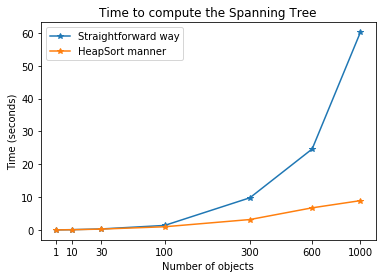

xaxis [   1   10   30  100  300  600 1000]
yaxis_old [0.031733, 0.110667, 0.325264, 1.391511, 9.799253, 24.652681, 60.184621]
yaxis_new [0.02645, 0.085939, 0.278405, 0.986002, 3.183306, 6.747965, 8.936661]


In [603]:
plt.plot(np.log1p(xaxis/50), yaxis_old, '*-', label='Straightforward way')
plt.plot(np.log1p(xaxis/50), yaxis_new, '*-', label='HeapSort manner')
plt.xticks(np.log1p(xaxis/50), xaxis)
plt.legend()
plt.ylabel('Time (seconds)')
plt.xlabel('Number of objects')
plt.title('Time to compute the Spanning Tree')
plt.show()

print('xaxis', xaxis)
print('yaxis_old', yaxis_old)
print('yaxis_new', yaxis_new)

In [562]:
%%time
fm._construct_spanning_tree()


CPU times: user 36.5 s, sys: 256 ms, total: 36.7 s
Wall time: 36.4 s


In [563]:
%%time
fm._construct_spanning_tree_old()

KeyboardInterrupt: 

In [520]:
%%time
fm._construct_spanning_tree()


CPU times: user 1.53 s, sys: 28 ms, total: 1.56 s
Wall time: 1.56 s


In [321]:
%%time
fm._construct_lattice_connections()


CPU times: user 1min 43s, sys: 355 ms, total: 1min 43s
Wall time: 1min 43s


In [385]:
fm.get_concept_by_id(100)._low_neighbs

In [386]:
fm.get_concept_by_id(100)._up_neighb_st

86

In [465]:
for c in fm.get_concepts():
    c._metrics['mean_y_true'] = ds.loc[[int(g) for g in c.get_extent()], y_feat ].mean()

In [466]:
len(X_train), len(X_test)

(23000, 9561)

In [467]:
fm.get_concept_by_id(10)._metrics

{'mean_y_true': 0.1590541165587419}

In [468]:
preds_train_fm = fm.predict_context(cntx_train, )

In [474]:
%%timeit
preds_train_fm = fm.predict_context(cntx_train)

1.51 s ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [475]:
%%timeit
preds_test_fm = fm.predict_context(cntx_test)

800 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [476]:
%%timeit
preds_train_rf = rf.predict_proba(X_train)

496 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [477]:
%%timeit
preds_test_rf = rf.predict_proba(X_test)

216 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [480]:
roc_auc_score(y_train, preds_train_fm), roc_auc_score(y_test, preds_test_fm)

(0.6841536742732579, 0.858339613334128)

In [481]:
roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

(0.9999993701705091, 0.8740482824678789)

In [293]:
%%timeit
preds_train_fm = fm.predict_context(cntx_train)

12.1 s ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [294]:
%%timeit
preds_test_fm = fm.predict_context(cntx_test)

6.4 s ± 64.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [295]:
%%timeit
preds_test_rf = rf.predict_proba(X_test)

215 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [296]:
%%timeit
preds_train_rf = rf.predict_proba(X_train)

443 ms ± 44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%%timeit
preds_train_fm = fm.predict_context(cntx_train)

23.5 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
%%timeit
preds_test_fm = fm.predict_context(cntx_test)

10.3 s ± 34.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
%%timeit
preds_test_rf = rf.predict_proba(X_test)

196 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%%timeit
preds_train_rf = rf.predict_proba(X_train)

432 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
len(preds_test_fm)

9561

In [88]:
from sklearn.metrics import roc_auc_score

In [92]:
roc_auc_score(y_train, preds_train_fm), roc_auc_score(y_test, preds_test_fm)

(0.8548532120429563, 0.858339613334128)

In [99]:
roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

(0.9999993701705091, 0.8740482824678789)

In [60]:
cntx_train_small = fcai.MultiValuedContext(ds.loc[train_idxs, train_feats].head(100), y_true=y_train[:100], cat_attrs=cat_feats)cntx_test_small = fcai.MultiValuedContext(ds.loc[test_idxs, train_feats].head(100), cat_attrs=cat_feats)

In [215]:
len(fm.get_concepts())

445

In [201]:
len(fm.get_concepts())

80

In [187]:
concepts

[PatternStructure
 
 extent (len: 10014): 2, 6, 13, 16, 17, 21, 24, 26, 28, 30, 31, 33, 35, 36, 43, 44, 49, 51, 54, 61, 64, 66, 69, 70, 73, 74, 75, 78, 80, 84, 85, 88, 91, 92, 95, 98, 99, 103, 104, 106, 107, 108, 114, 119, 120, 124, 126, 129, 130, 131, 134, 138, 141, 142, 143, 144, 145, 147, 149, 150, 151, 153, 154, 157, 158, 160, 161, 163, 165, 166, 168, 169, 170, 175, 176, 177, 178, 181, 182, 190, 195, 196, 199, 201, 203, 204, 205, 207, 209, 212, 216, 219, 221, 222, 224, 225, 226, 228, 229, 230, 231, 232, 233, 236, 239, 243, 244, 247, 252, 253, 254, 256, 257, 258, 259, 262, 266, 271, 274, 277, 278, 282, 284, 287, 291, 293, 298, 299, 301, 305, 306, 307, 312, 314, 315, 317, 318, 319, 322, 323, 326, 329, 330, 332, 335, 336, 338, 340, 343, 344, 347, 348, 356, 364, 367, 369, 370, 371, 374, 375, 377, 380, 381, 383, 385, 386, 388, 389, 392, 394, 396, 397, 400, 401, 403, 410, 411, 412, 415, 417, 418, 419, 421, 423, 424, 427, 430, 431, 434, 436, 437, 441, 442, 444, 445, 446, 449, 450, 460, 46

In [186]:
len(concepts)

80

In [172]:
from joblib import Parallel, delayed

In [174]:
tree = rf.estimators_[0]

In [177]:
paths = tree.decision_path(X_train)
#exts = [list(objs[(paths[:, i] == 1).todense().flatten().tolist()[0]]) for i in range(paths.shape[1])]

In [230]:
objs = X_train.index

In [238]:
%%timeit
list(objs[(paths[:, 0] == 1).todense().flatten().tolist()[0]])

6.49 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [232]:
paths_dense = paths.todense()

In [247]:
%%timeit
list(objs[(paths_dense[:, 0] == 1).flatten().tolist()[0]])

5.09 ms ± 624 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [241]:
paths_csc = paths.tocsc()

In [249]:
%%timeit
list(objs[(paths_csc[:, 0] == 1).todense().flatten().tolist()[0]])

5.05 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [243]:
paths_csc_dense = paths_csc.todense()

In [248]:
%%timeit
list(objs[(paths_csc_dense[:, 0] == 1).flatten().tolist()[0]])

4.33 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
RandomForestClassifier(n_jobs=-1)

In [291]:
f = lambda i, paths: list(objs[(paths[:, i] == 1).todense().flatten().tolist()[0]])

In [289]:
from datetime import datetime

In [290]:
paths_csc

<23000x7695 sparse matrix of type '<class 'numpy.longlong'>'
	with 370789 stored elements in Compressed Sparse Column format>

In [295]:
xaxis = [1, 10, 100, 1000, 3000, 7695]
yaxis_before = []
yaxis_par = []
yaxis_ = []
for n in tqdm(xaxis):
    dt1 = datetime.now()
    [f(i, paths) for i in range(n)]
    dt2 = datetime.now()
    yaxis_before.append((dt2-dt1).total_seconds())
    
    dt1 = datetime.now()
    [f(i, paths_csc) for i in range(n)]
    dt2 = datetime.now()
    yaxis_.append((dt2-dt1).total_seconds())
    
    dt1 = datetime.now()
    Parallel(-1)([delayed(f)(i, paths_csc) for i in range(n)])
    dt2 = datetime.now()
    yaxis_par.append((dt2-dt1).total_seconds())

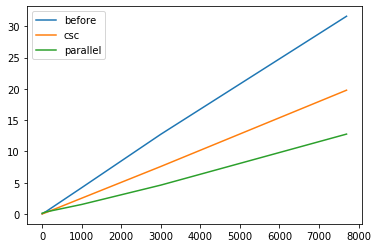

In [297]:
plt.plot(xaxis, yaxis_before, label='before')
plt.plot(xaxis, yaxis_, label='csc')
plt.plot(xaxis, yaxis_par, label='parallel')
plt.legend()
plt.show()

In [301]:
np.array(yaxis_before)/np.array(yaxis_par)

array([0.09620932, 0.66160079, 1.18700697, 2.76229871, 2.7610525 ,
       2.47530616])

In [299]:
yaxis_before[-1]/yaxis_par[-1]

2.475306157131815

In [298]:
yaxis_[-1]/yaxis_par[-1]

1.5495175337953462

In [171]:
mtrx.T.todense().shape

(7695, 23000)

In [35]:
fcai = reload(fcai)

In [42]:
fm.construct_lattice(True)

In [43]:
for c in fm.get_concepts():
    c._metrics['mean_y_true'] = y_train.loc[[int(x) for x in c.get_extent()]].mean()

In [44]:
preds_fm = fm.predict_context(cntx_test,)

In [50]:
preds_fm = np.array(preds_fm)

In [52]:
accuracy_score(y_test, preds_fm>=0.5), f1_score(y_test, preds_fm>=0.5), log_loss(y_test, preds_fm)

(0.815814245371823, 0.5093340763443857, 0.41530440477265046)

In [126]:
accuracy_score(y_test, preds), f1_score(y_test, preds), log_loss(y_test, model.predict_proba(X_test))

(0.8467733500679845, 0.6566674478556362, 0.3348993864031587)